# EDS Cover

Political Alignment Case Study

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [3]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from empiricaldist import Pmf

In [5]:
def values(series):
    """Count the values and sort.
    
    series: pd.Series
    
    returns: series mapping from values to frequencies
    """
    return series.value_counts().sort_index()

In [6]:
def decorate(**options):
    """Decorate the current axes.
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    plt.gca().set(**options)
    plt.tight_layout()

In [121]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def make_lowess(series, **options):
    """Use LOWESS to compute a smooth line.
    
    series: pd.Series
    
    returns: pd.Series
    """
    y = series.values
    x = series.index.values

    smooth = lowess(y, x, **options)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index) 

In [98]:
def plot_series_lowess(series, color):
    """Plots a series of data points and a smooth line.
    
    series: pd.Series
    color: string or tuple
    """
    series.plot(linewidth=0, marker='o', color=color, alpha=0.5)
    smooth = make_lowess(series)
    smooth.plot(label='_', color=color, lw=4)

In [9]:
def plot_columns_lowess(table, columns, color_map):
    """Plot the columns in a DataFrame.
    
    table: DataFrame with a cross tabulation
    columns: list of column names, in the desired order
    color_map: mapping from column names to color_map
    """
    for col in columns:
        series = table[col]
        plot_series_lowess(series, color_map[col])

In [10]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/PoliticalAlignmentCaseStudy/' +
         'raw/master/gss_eda.3.hdf5')

In [11]:
datafile = 'gss_eda.3.hdf5'
gss = pd.read_hdf(datafile, 'gss0')
gss.shape

(64814, 169)


## Attitudes about homosexuality



In [29]:
values(gss['homosex'])

1.0    23545
2.0     1678
3.0     2586
4.0     9863
5.0       94
Name: homosex, dtype: int64

And here's what the distribution looks like.

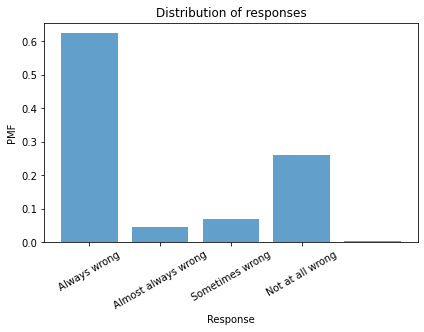

In [30]:
pmf = Pmf.from_seq(gss['homosex'])
pmf.bar(alpha=0.7)

decorate(xlabel='Response',
         ylabel='PMF',
         title='Distribution of responses')

responses = [1, 2, 3, 4]

labels = ['Always wrong',
          'Almost always wrong',
          'Sometimes wrong',
          'Not at all wrong']

plt.xticks(responses, labels, rotation=30);

In [31]:
xtab = pd.crosstab(gss['year'], gss['homosex'], normalize='index')
xtab.head()

homosex,1.0,2.0,3.0,4.0,5.0
year,,,,,
1973,0.724066,0.057400,0.082988,0.112725,0.022822
1974,0.709972,0.047051,0.073736,0.126404,0.042837
1976,0.679806,0.057400,0.089212,0.173582,0.000000
1977,0.729767,0.062414,0.071331,0.136488,0.000000
1980,0.725772,0.055994,0.058148,0.160086,0.000000


In [32]:
xtab.tail()

homosex,1.0,2.0,3.0,4.0,5.0
year,,,,,
2010,0.474838,0.033279,0.077922,0.413961,0.0
2012,0.449878,0.029340,0.075795,0.444988,0.0
2014,0.388069,0.029520,0.077491,0.504920,0.0
2016,0.379444,0.036667,0.075000,0.508889,0.0
2018,0.332471,0.034282,0.057568,0.575679,0.0


Now we can plot the results.

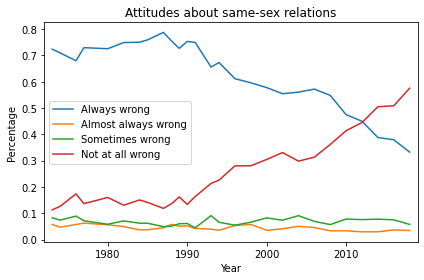

In [33]:
for response, label in zip(responses, labels):
    xtab[response].plot(label=label)

decorate(xlabel='Year',
         ylabel='Percentage',
         xlim=[1972, 2019],
         title='Attitudes about same-sex relations')

plt.legend();

## Political alignment

To explore the relationship between this variable and political alignment, I'll recode political alignment into three groups:

In [34]:
d_polviews = {1: 'Liberal', 
              2: 'Liberal', 
              3: 'Liberal', 
              4: 'Moderate', 
              5: 'Conservative', 
              6: 'Conservative', 
              7: 'Conservative'}

I'll use `replace`, as we've seen before, and store the result as a new column in the DataFrame.

In [35]:
gss['polviews3'] = gss['polviews'].replace(d_polviews)

With this scale, there are roughly the same number of people in each group.

In [36]:
values(gss['polviews3'])

Conservative    19129
Liberal         14979
Moderate        21444
Name: polviews3, dtype: int64

## Group by political alignment

Now we can use `groupby` to group the respondents by political alignment.

In [37]:
by_polviews = gss.groupby('polviews3')

Next I will plot the distribution of responses in each group.

But first I'll make a dictionary that maps from each group to a color.

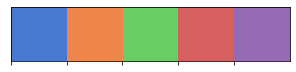

In [38]:
muted = sns.color_palette('muted', 5)
sns.palplot(muted)

In [39]:
color_map = {'Conservative': muted[3], 
              'Moderate': muted[4], 
               'Liberal': muted[0]}

## Recode

For each group, we could compute the mean of the responses, but it would be hard to interpret. So we'll recode the variable of interest to make the mean more... meaningful.

For the variable I chose, a majority of respondents chose "always wrong".  I'll use that as my baseline response with code 1, and lump the other responses with code 0.

In [40]:
d_recode = {1:0, 2:0, 3:0, 4:1, 5:0}

We can use `replace` to recode the values and store the result as a new column in the DataFrame.

In [41]:
gss['recoded'] = gss['homosex'].replace(d_recode)

And we'll use `values` to check whether it worked.

In [42]:
values(gss['recoded'])

0.0    27903
1.0     9863
Name: recoded, dtype: int64

If we compute the mean, we can interpret it as "the fraction of respondents who think same-sex sexual relations are always wrong".

In [43]:
gss['recoded'].mean()

0.26116082

## Average by group



Now we can compute the mean of the recoded variable in each group.

In [44]:
means = by_polviews['recoded'].mean()
means

polviews3
Conservative    0.168922
Liberal         0.421140
Moderate        0.257352
Name: recoded, dtype: float32

To get the values in a particular order, we can use the group names as an index:

In [45]:
names = color_map.keys()
names

dict_keys(['Conservative', 'Moderate', 'Liberal'])

In [46]:
means[names]

polviews3
Conservative    0.168922
Moderate        0.257352
Liberal         0.421140
Name: recoded, dtype: float32

Now we can make a bar plot with color-coded bars:

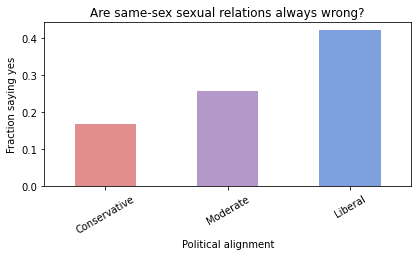

In [47]:
colors = color_map.values()

means[names].plot(kind='bar', color=colors, alpha=0.7)

decorate(xlabel='Political alignment',
         ylabel='Fraction saying yes',
         title='Are same-sex sexual relations always wrong?')

plt.xticks(rotation='30');

As we might expect, more conservatives think homosexuality is "always wrong", compared to moderates and liberals.

## Time series

As we saw in previous notebooks, we can use `groupby` to group responses by year.

In [48]:
by_year = gss.groupby('year')

From the result we can select the recoded variable and compute the mean.

In [49]:
time_series = by_year['recoded'].mean()

And we can plot the results with the data points themselves as circles and a local regression model as a line.

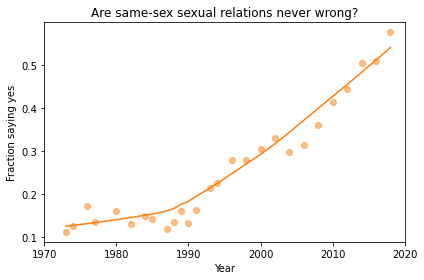

In [51]:
plot_series_lowess(time_series, 'C1')

decorate(xlabel='Year',
         ylabel='Fraction saying yes',
         xlim=[1970, 2020],
         title='Are same-sex sexual relations never wrong?')

The fraction of respondents who think homosexuality is wrong has been falling steeply since about 1990.

## Time series by group

So far, we have grouped by `polviews3` and computed the mean of the variable of interest in each group.

Then we grouped by `year` and computed the mean for each year.

Now we'll use `pivot_table` to compute the mean in each group for each year.

In [52]:
table = gss.pivot_table(values='recoded', 
                        index='year', 
                        columns='polviews3', 
                        aggfunc='mean')

The result is a table that has years running down the rows and political alignment running across the columns.

Each entry in the table is the mean of the variable of interest for a given group in a given year.

In [53]:
table.head()

polviews3,Conservative,Liberal,Moderate
year,,,
1974,0.065693,0.206977,0.117988
1976,0.131818,0.302030,0.125704
1977,0.083527,0.227603,0.119508
1980,0.082547,0.298551,0.145299
1982,0.127580,0.202405,0.091757


## Plotting the results

Now we can use `plot_columns_lowess` to see the results.

In [135]:
columns = ['Liberal', 'Moderate', 'Conservative']
names = ['Getting Started with', 'Data Science and Python', 'by Allen B. Downey']
markers = 'so^'

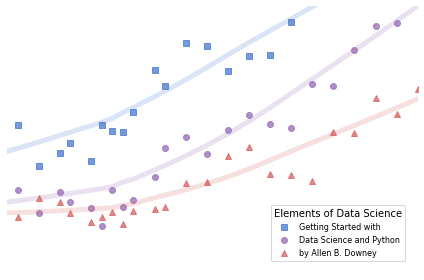

In [138]:
import seaborn as sns

for col, name, marker in zip(columns, names, markers):
    series = table[col]
    series.name = name
    color = color_map[col]
    series.plot(linewidth=0, marker=marker, ms=6, color=color, alpha=0.75)
    smooth = make_lowess(series, frac=0.75)
    smooth.plot(label='_', color=color, lw=5, alpha=0.2)
        
decorate(xlabel='Year',
         xlim=[1979, 2018],
         ylim=[-0.05, 0.58],)

plt.axis('off')

plt.legend(title='Elements of Data Science', 
           title_fontsize=10,
           fontsize=8,
           loc='lower right',
           bbox_to_anchor=[0.98, 0.03]);

plt.tight_layout()
plt.savefig('eds_cover.pdf')

Negative attitudes about homosexuality have been declining in all three groups, starting at about the same time, and at almost the same rate.

## Resampling

The figures we have generated so far in this notebook are based on a single resampling of the GSS data.  Some of the features we see in these figures might be due to random sampling rather than actual changes in the world.

By generating the same figures with different resampled datasets, we can get a sense of how much variation there is due to random sampling.

To make that easier, the following function contains the code from the previous analysis all in one place.

You will probably have to update this function with any changes you made in my code.

In [39]:
def plot_by_polviews(gss):
    """Plot mean response by polviews and year.
    
    gss: DataFrame
    """
    gss['polviews3'] = gss['polviews'].replace(d_polviews)
    gss['recoded'] = gss['homosex'].replace(d_recode)
    
    table = gss.pivot_table(values='recoded', 
                        index='year', 
                        columns='polviews3', 
                        aggfunc='mean')

    plot_columns_lowess(table, columns, color_map)

    decorate(xlabel='Year',
             ylabel='Fraction saying yes',
             xlim=[1970, 2020],
             title='Are same-sex relations always wrong?')

Now we can loop through the three resampled datasets in the HDF5 file and generate a figure for each one.

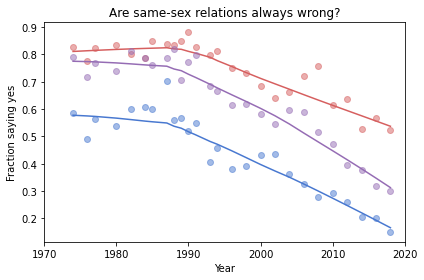

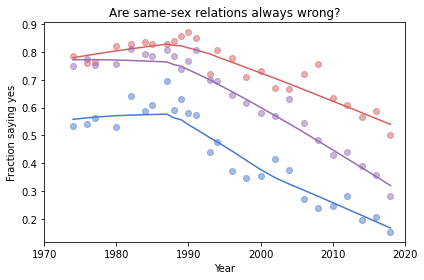

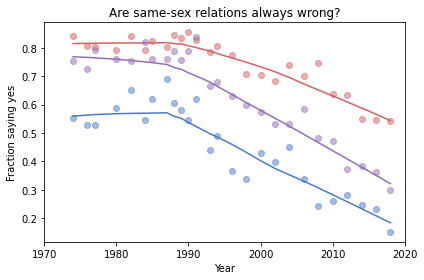

In [40]:
for key in ['gss0', 'gss1', 'gss2']:
    df = pd.read_hdf('gss_eda.3.hdf5', key)

    plt.figure()
    plot_by_polviews(df)

You should review your interpretation in the previous section to see how it holds up to resampling.  If you see an effect that is consistent in all three figures, it is less likely to be an artifact of random sampling.

If it varies from one resampling to the next, you should probably not take it too seriously.